# UCI Diabetes - Readmission in 3 months or not? 

In this project, several models will be created from the UCI diabetes dataset that will predict whether a patient is likely to be readmitted to the hospital for diabetes in 30 days or not. 

## Import packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import Normalizer

from sklearn.feature_selection import chi2, SelectPercentile
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron

from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Analysis
Start by reading in the data and removing extraneous information of individual patients. 

In [2]:
# Read in dataset 
df = pd.read_csv("diabetic_data.csv", na_values = "?", low_memory = False)

# Drop observation specific features 
df = df.drop(["encounter_id", "patient_nbr"], axis = 1)

# Display class label counts
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [3]:
# Adjust to binary classification problem
df.readmitted = df.readmitted.apply(lambda x: 1 if x == '<30' else 0)

In [4]:
# Check class labels 
print("After adjusting the class labels, \n", 
      'total number of class 0 (’NO’ and ’>30’) instances:',
      len(df.loc[df['readmitted'] == 0, 'readmitted']), "\n",
      "total number of class 1 (’< 30’) instances:",
      len(df.loc[df['readmitted'] == 1, 'readmitted']))

After adjusting the class labels, 
 total number of class 0 (’NO’ and ’>30’) instances: 90409 
 total number of class 1 (’< 30’) instances: 11357


Note which columns have continuous data and which have categorical data. If a certain column is of a wrong type, change it to the other type. 

In [5]:
# List the type of feature each column is 
df.columns.groupby(df.dtypes)

{dtype('int64'): Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_outpatient', 'number_emergency',
        'number_inpatient', 'number_diagnoses', 'readmitted'],
       dtype='object'),
 dtype('O'): Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
        'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
        'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
        'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
        'tolazamide', 'examide', 'citoglipton', 'insulin',
        'glyburide-metformin', 'glipizide-metformin',
        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
        'metformin-pioglitazone', 'change', 'diabetesMed'],
       dtype='object')}

IDs are to be treated as categorical data rather than as numbers. The 3 ID columns are mistaken for numerical columns. Therefore change those to string types.

In [6]:
# Change ID columns from numerical to string type 
df.admission_type_id = df.admission_type_id.astype('str')
df.discharge_disposition_id = df.discharge_disposition_id.astype('str')
df.admission_source_id = df.admission_source_id.astype('str')

## Exploratory Data Analysis

In [7]:
# What is the size of the dataset
df.shape

(101766, 48)

There are $101,766$ records in the dataset. Explore the dataset. If a certain column is overly populated by a frequent value, over $98\%$, remove the column from the dataset. 

To find heavy tailed distributions, first find a cutoff point.

In [8]:
# Find cut off point
0.98 * df.shape[0]

99730.68

Find the columns where at least $99,731$ rows have the same value.

In [9]:
# Get list of features ordered by top most frequent values
df.describe(exclude = ['int64']).T.sort_values(by = ['freq'], ascending = False)

,count,unique,top,freq
examide,101766,1,No,101766
citoglipton,101766,1,No,101766
glimepiride-pioglitazone,101766,2,No,101765
acetohexamide,101766,2,No,101765
metformin-pioglitazone,101766,2,No,101765
metformin-rosiglitazone,101766,2,No,101764
troglitazone,101766,2,No,101763
glipizide-metformin,101766,2,No,101753
tolbutamide,101766,2,No,101743
miglitol,101766,4,No,101728


The $16$ columns that are over $98\%$ saturated with one value are: _examide_, _citoglipton_, _glimepiride-pioglitazone_, _acetohexamide_, _metformin-pioglitazone_, _metformin-rosiglitazone_, _troglitazone_, _glipizide-metformin_, _tolbutamide_, _miglitol_, _tolazamide_, _chlorpropamide_, _acarbose_, _nateglinide_, _glyburide-metformin_ and _repaglinide_. Remove those from the dataframe. 

In [10]:
# Drop the overly saturated features 
df = df.drop(['examide', 'citoglipton', 'glimepiride-pioglitazone', 
              'acetohexamide', 'metformin-pioglitazone', 
              'metformin-rosiglitazone', 'troglitazone', 
              'glipizide-metformin', 
              'tolbutamide', 'miglitol', 'tolazamide', 
              'chlorpropamide', 
              'acarbose', 'nateglinide', 'glyburide-metformin',
              'repaglinide'], axis = 1)

In [11]:
# What is the new length of the dataset? 
df.shape

(101766, 32)

An important note about this dataset is that there are $3$ columns designated for diagnoses. These columns give the icd$9$ code for what the patient was diagnosed with on the primary and two secondary diagnoses. According to the research article that was published alongside with the dataset, these diagnoses can be coded into a larger group for our use. These groups are circulatory, respiratory, digestive, diabetes, injury, musculoskeletal, genitourinary, neoplasms, symptoms, skin/tissue, parasitic and others. The others group makes up $17.3\%$ of the dataset and is broken down into $7$ smaller groups each of having $2.2\%$ or less occurrence in the dataset. 

Source: https://www.hindawi.com/journals/bmri/2014/781670/ 

Thus code the diagnoses columns into these groups.

In [12]:
# A function to categorize diagnosis icd9 codes
def diag_group(df, col):
    new_diags = []
    for i in df[col]: 
        if pd.isnull(i): new_diags.append(np.nan)
        else: 
            try:
                val = float(i)
                if (val >= 390 and val <= 460) or val == 785: 
                    new_diags.append("circulatory")
                elif (val >= 460 and val <= 520) or val == 786: 
                    new_diags.append("respiratory")
                elif (val >= 520 and val <= 580) or val == 787: 
                    new_diags.append("digestive")
                elif (val >= 250 and val < 251): 
                    new_diags.append("injury")
                elif (val >= 710 and val <= 740): 
                    new_diags.append("musculoskeletal")
                elif (val >= 580 and val <= 630) or val == 788: 
                    new_diags.append("genitourinary")
                elif (val >= 140 and val <= 240): 
                    new_diags.append("neoplasms")
                elif (val in [780, 781, 784]) or (val >= 790 and val <= 799):
                    new_diags.append("other symptoms")
                elif (val >= 240 and val <= 280): 
                    new_diags.append("endocrine/nutritional")
                elif (val >= 680 and val <= 709) or val == 782: 
                    new_diags.append("skin/tissue")
                elif (val >= 1 and val <= 139): 
                    new_diags.append("infection/parasitic")
                else: new_diags.append("other")
            except:
                new_diags.append("other")
    return new_diags

In [13]:
# Fill in diagnosis category for all 3 diagnosis features 
df["diag_1"] = diag_group(df, "diag_1")
df["diag_2"] = diag_group(df, "diag_2")
df["diag_3"] = diag_group(df, "diag_3")

There are $72$ different medical specialties with the most common one being present in only $14.3\%$ of the dataset. To simplify this feature, if any specialty appears in the dataset with an occurence of less than $0.5\%$, change it to _other_. 

In [14]:
# Get list of top frequent appearing medical specialties
med_spec = np.where(100 * df.medical_specialty.value_counts() / df.shape[0] > 0.5)[0]
med_spec = list(df.medical_specialty.value_counts()[med_spec].index)

# For each attribute, if it is common, keep it
# Otherwise change it to other 
new_med_spec = []
for i in df.medical_specialty:
    if i in med_spec or pd.isnull(i): new_med_spec.append(i)
    else: new_med_spec.append("other")
df['medical_specialty'] = new_med_spec

In [15]:
# Get number of different medical specialties
df.medical_specialty.value_counts().count()

17

Now look at the continuous columns. 

In [16]:
# Display the continuous features and their statistics
df.describe(exclude = ['object']).T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0
number_diagnoses,101766.0,7.422607,1.933600,1.0,6.0,8.0,9.0,16.0
readmitted,101766.0,0.111599,0.314874,0.0,0.0,0.0,0.0,1.0


Create two lists, one for categorical features and one for continous features 

In [17]:
# Group the features by their type
df.columns.groupby(df.dtypes)

{dtype('int64'): Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_outpatient', 'number_emergency',
        'number_inpatient', 'number_diagnoses', 'readmitted'],
       dtype='object'),
 dtype('O'): Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
        'discharge_disposition_id', 'admission_source_id', 'payer_code',
        'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
        'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide',
        'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed'],
       dtype='object')}

In [18]:
# Create 2 lists, one for continuous features 
# and one for categorical features 
num_feats = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_outpatient', 'number_emergency',
        'number_inpatient', 'number_diagnoses']

cat_feats = ['race', 'gender', 'age', 'weight', 'admission_type_id',
        'discharge_disposition_id', 'admission_source_id', 'payer_code',
        'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
        'A1Cresult', 'metformin', 'glimepiride', 'glipizide', 'glyburide',
        'pioglitazone', 'rosiglitazone', 'insulin', 'change']

The continous columns will be normalized as part of preprocessing so there are no extremities.

In [19]:
# Normalize the continuous features so it becomes continuous
df[num_feats] = Normalizer().fit_transform(df[num_feats])

Plot the features filtered by readmission

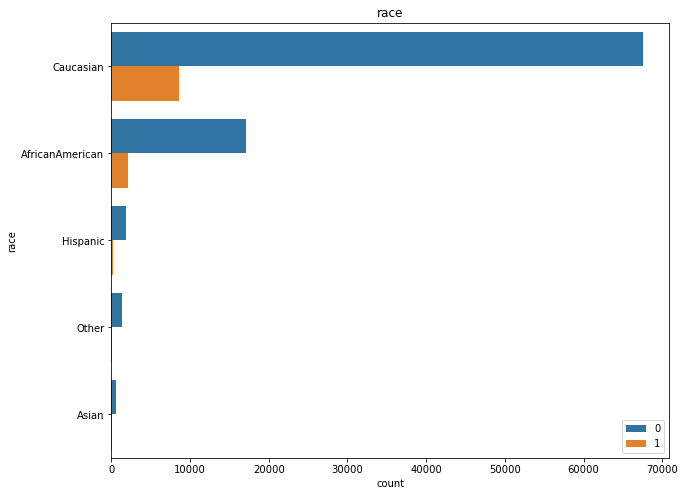

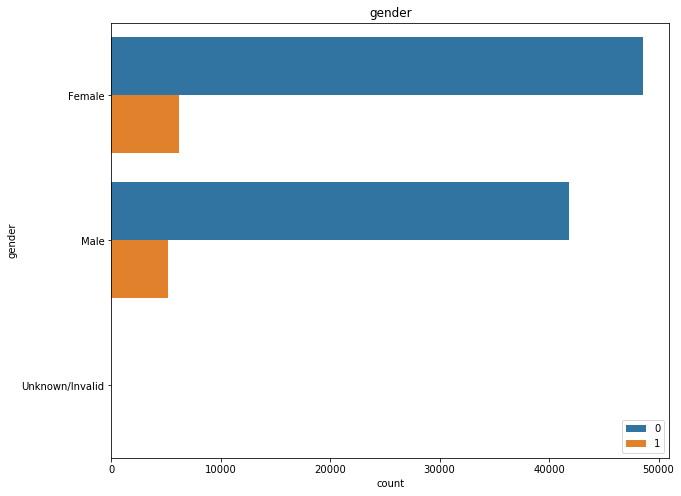

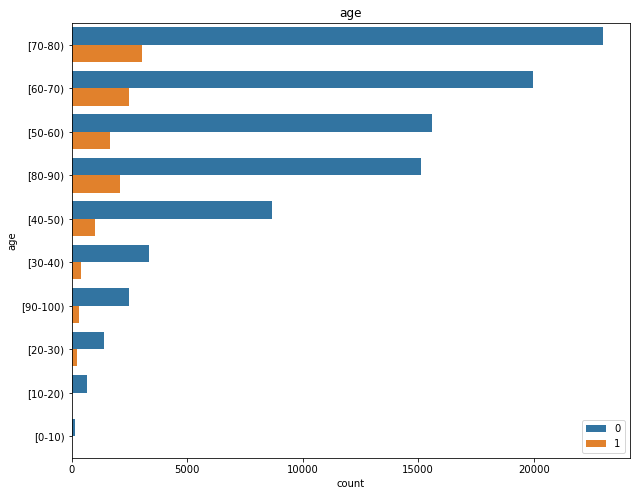

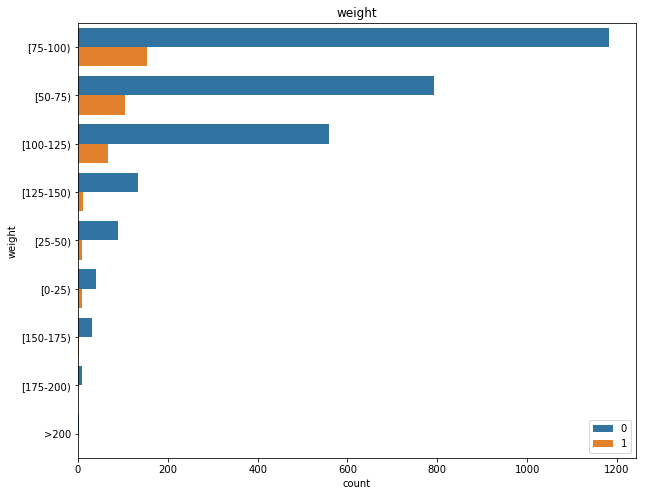

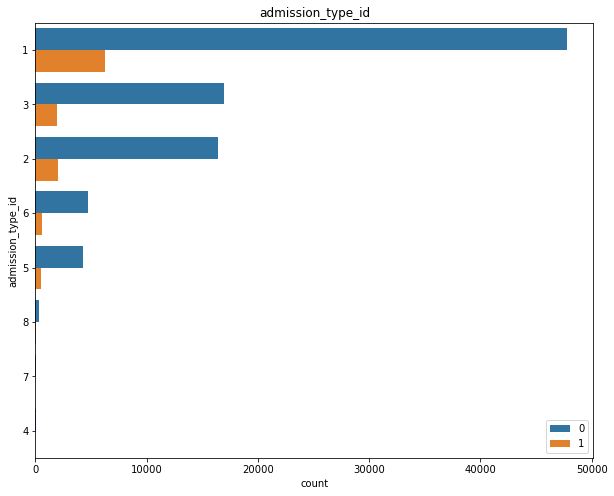

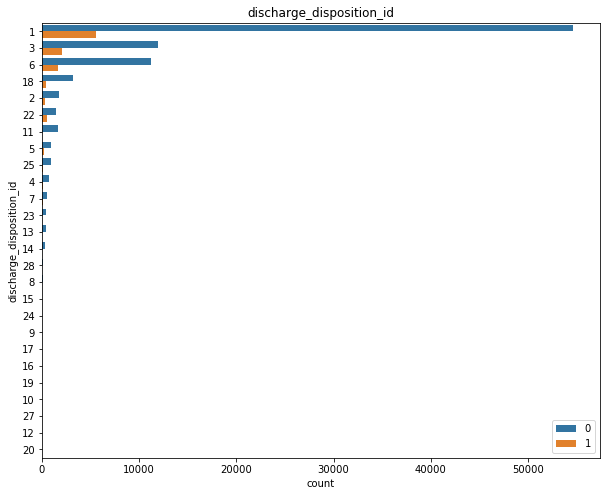

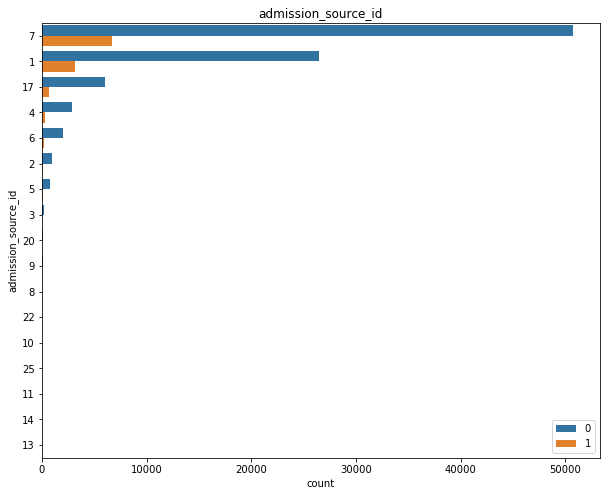

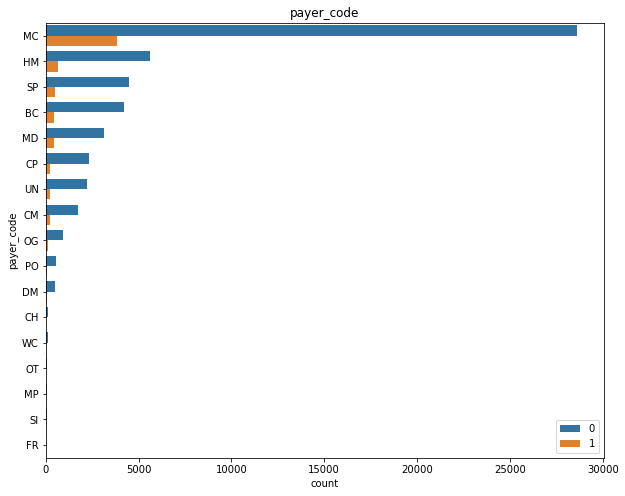

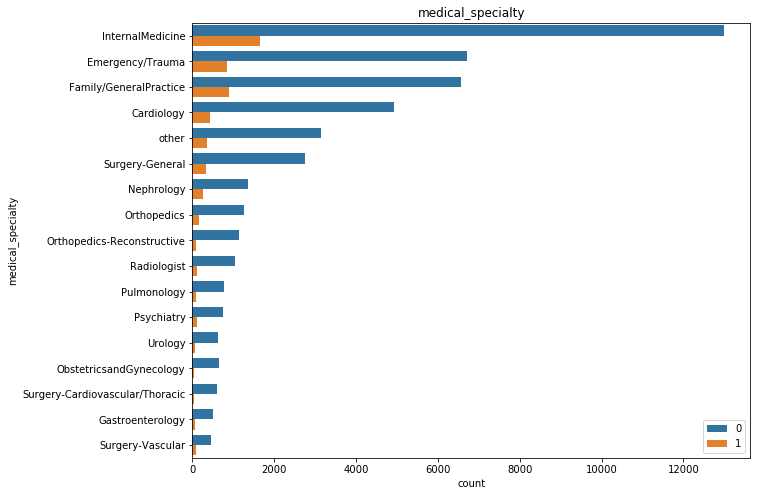

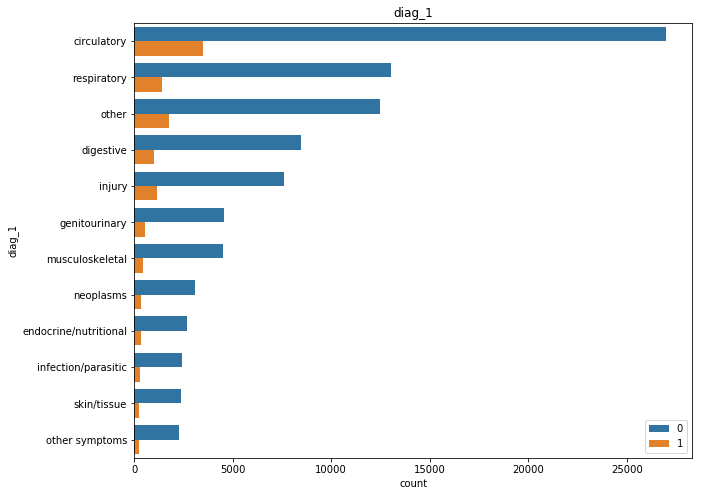

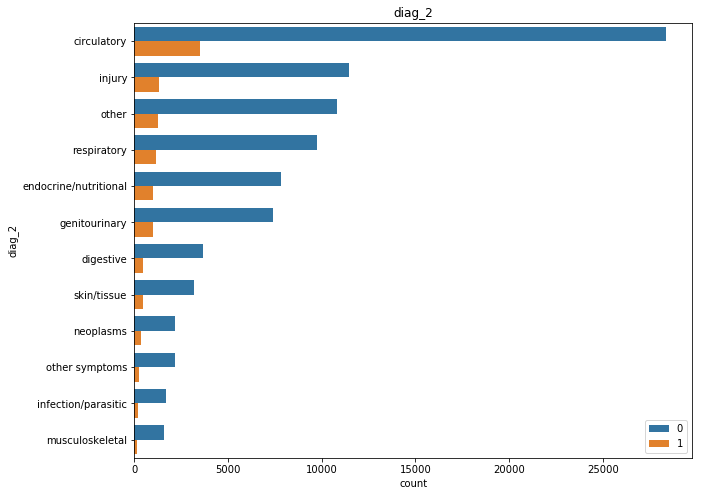

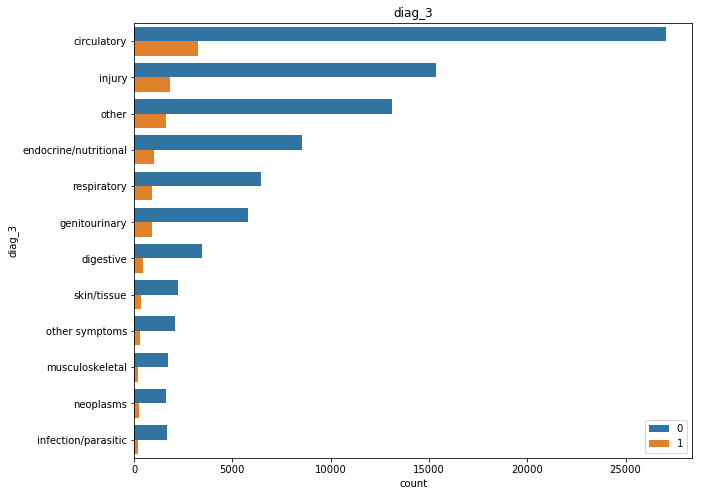

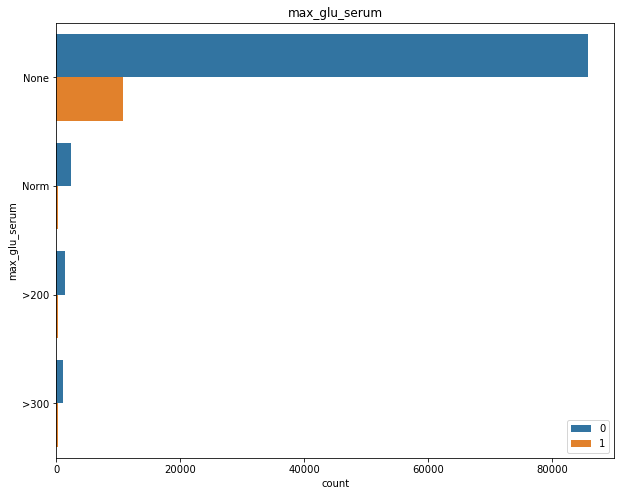

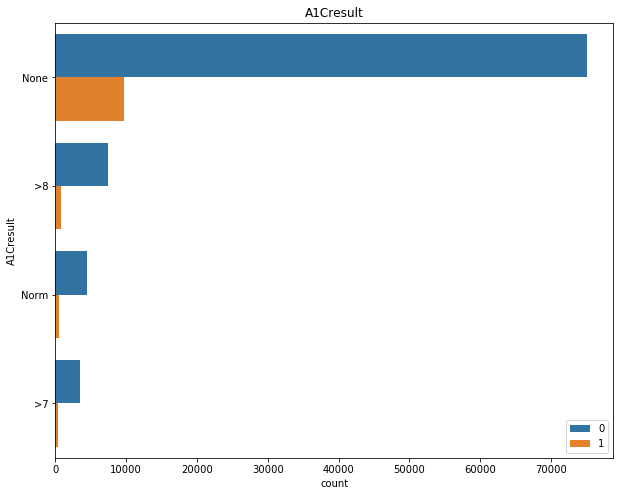

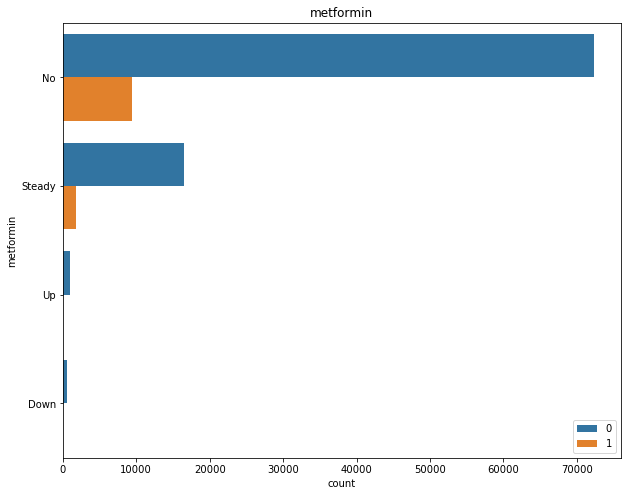

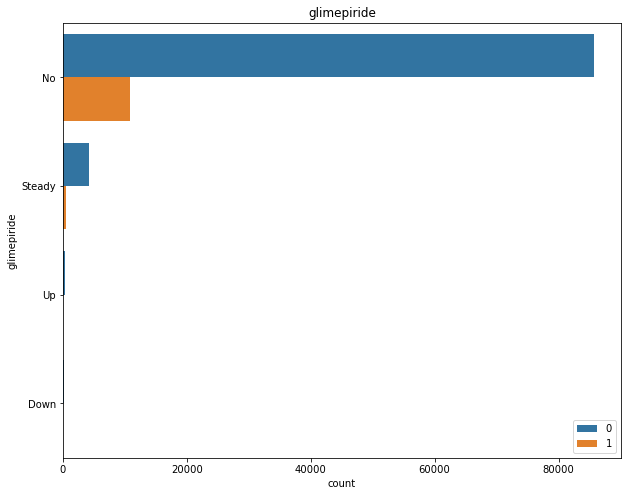

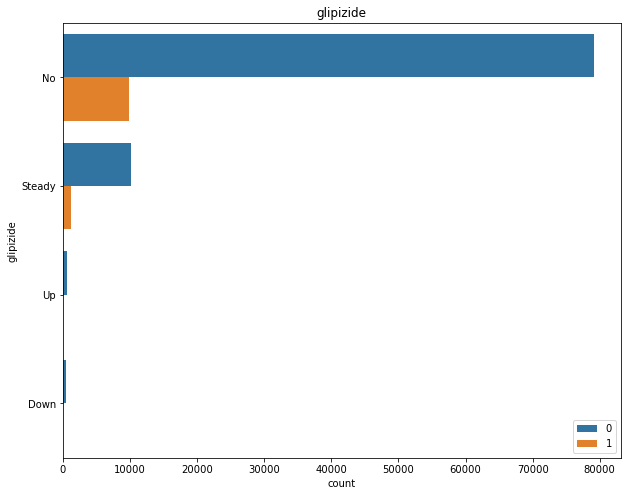

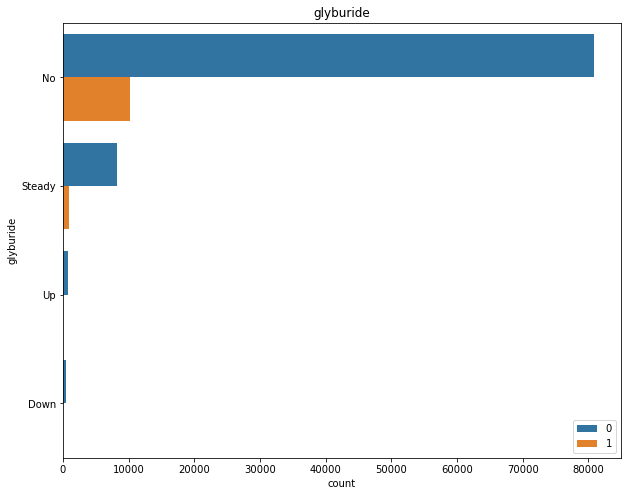

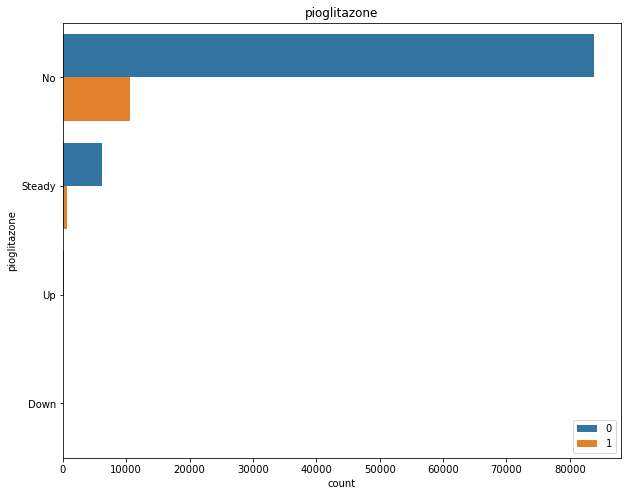

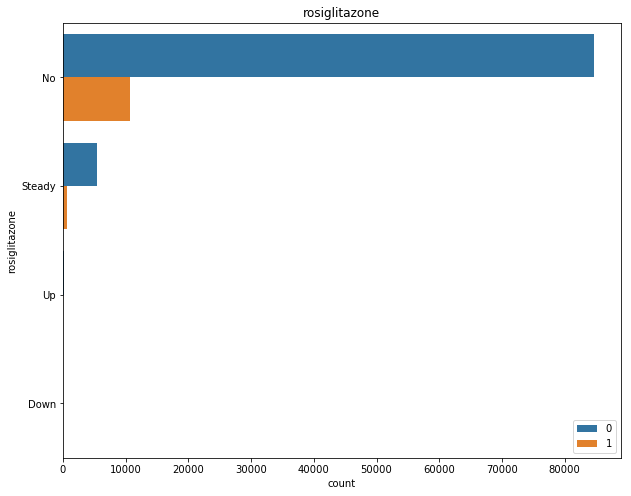

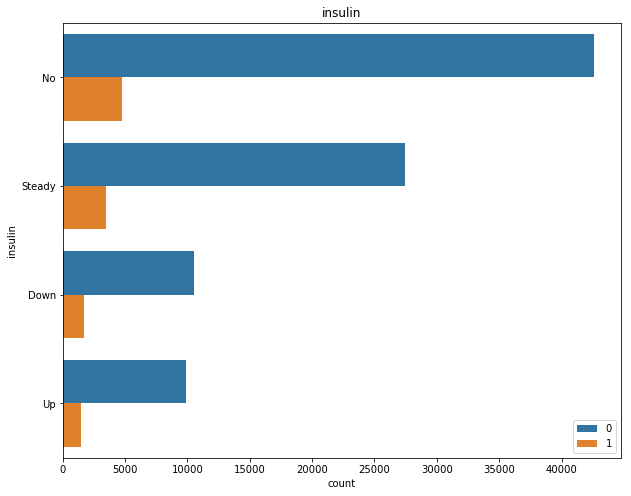

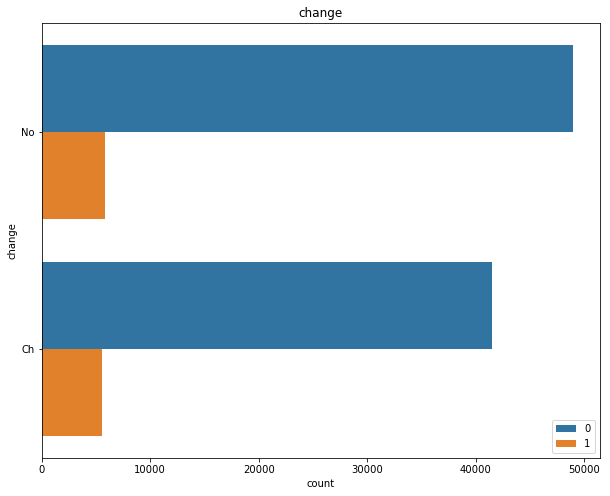

In [20]:
# Plot categorical features by readmission label
for i in cat_feats:
    fig = plt.figure(figsize = (10, 8))
    sns.countplot(y = df[i], hue = df.readmitted, order = df[i].value_counts().index)
    plt.title(i)
    plt.legend(loc = "lower right")
    plt.show()

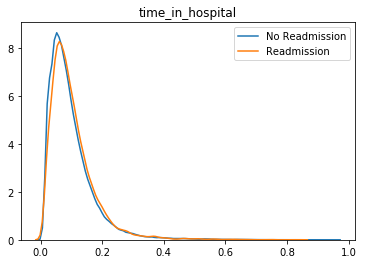

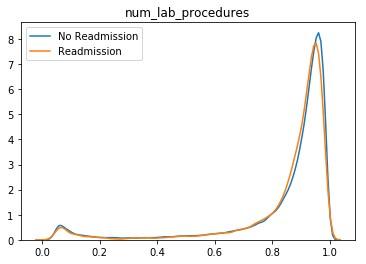

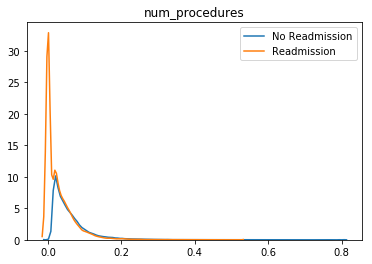

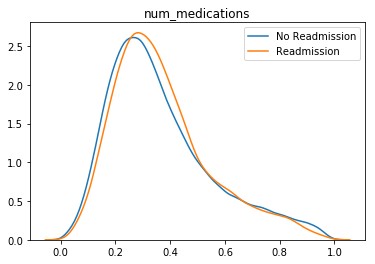

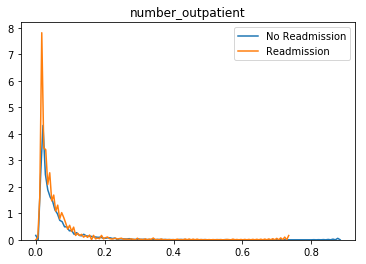

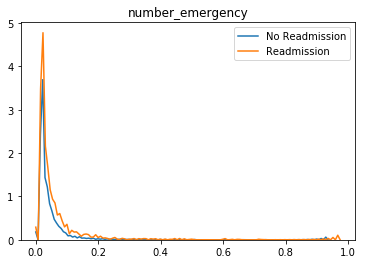

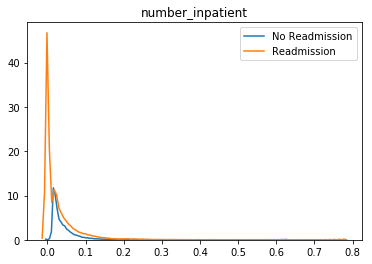

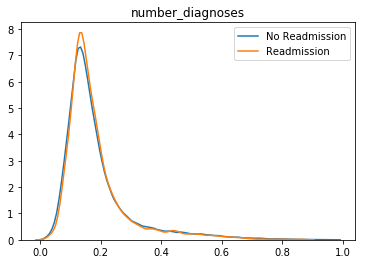

In [21]:
# Plot continuous features by readmission label
for i in num_feats:
    sns.kdeplot(df.loc[df.readmitted == 0, i])
    sns.kdeplot(df.loc[df.readmitted == 1, i])
    plt.title(i)
    plt.legend(['No Readmission', 'Readmission'])
    plt.show()

## Correlation of Features

The following heatmap shows the correlation of continous features. 

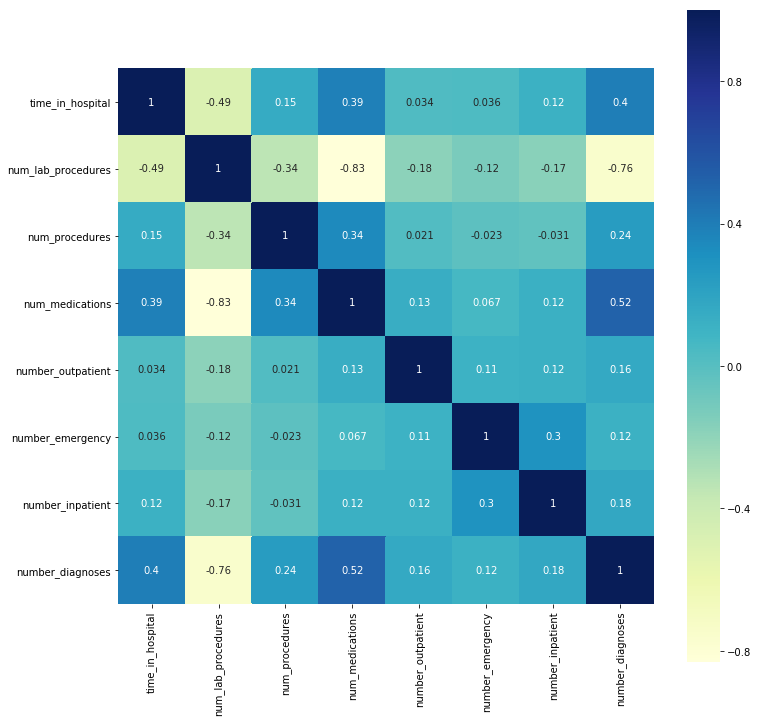

In [22]:
# Plot the correlation of features 
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df[num_feats].corr(), annot = True, cmap="YlGnBu", square = True, ax = ax)
plt.show()

## Missing Data

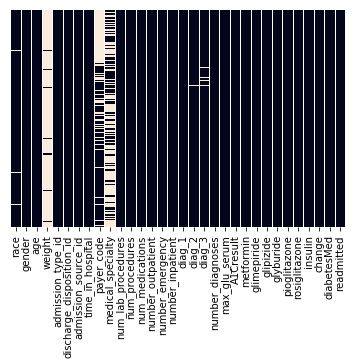

In [23]:
# Display the null features in the dataset using a heat map
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.show()

There is a lot of missing data in 3 columns. Let's look at how much exactly is missing. 

In [24]:
# Find the percentage of missing data in the dataset 
null_columns=df.columns[df.isnull().any()]
100*df[null_columns].isnull().sum()/df.shape[0]

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

The weight column is missing data in $96\%$ of its records. Drop it. 
The payer code and medical specialty column have moderate missing data.
The race and diags columns have little missing data.
Fill in missing data using a random forest. 

In [25]:
# Drop the weight column 
df = df.drop('weight', 1)
cat_feats.remove('weight')

## Missing Data - Random Forest

In [26]:
# A function to impute missing values using a RF classifier 
def missing_val_rf(old_df):
    
    df_rf = old_df.copy()
    for col in df_rf.columns[df_rf.isnull().any()]:
        Y = df_rf.loc[:,col]
        X = pd.get_dummies(df_rf.loc[:, df_rf.columns != col])

        Xtrain = X.loc[~Y.isnull()]
        Xtest = X.loc[Y.isnull()]
        Ytrain = Y.loc[~Y.isnull()]
        Ytest = Y.loc[Y.isnull()]

        clf = RandomForestClassifier(n_estimators=5)
        clf.fit(Xtrain, Ytrain)

        p = clf.predict(Xtest)
        Ytest = pd.DataFrame(p, index = Xtest.index)
        new_col = pd.concat([Ytrain, Ytest])
        df_rf[col] = new_col      
    return df_rf

In [27]:
# Fill in missing values 
df_rf_filled = missing_val_rf(df)

## Combine numerical and categorical data along with class label into one dataframe

In [28]:
# A function to combine data into a clean dataframe 
def combineData(df, cat, num, label):
    return pd.concat([pd.get_dummies(df.loc[:,cat_feats]), 
                      df.loc[:, num], df.loc[:, label]], axis = 1)

## Encode Features

Encode the categorical features and concat it with the numerical features and class label.

In [29]:
# Encode the categorical features and combine it with the continuous features 
feat_lab_rf = combineData(df_rf_filled, cat_feats, num_feats, "readmitted")

## Class Label Distribution

Look at the distribution of the class label. 

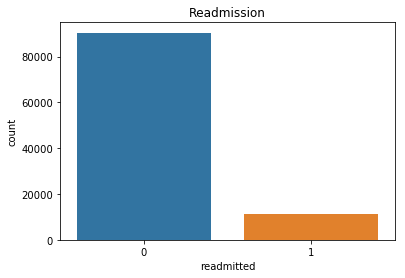

In [30]:
# Plot the counts of the readmission label 
sns.countplot(df.readmitted)
plt.title("Readmission")
plt.show()

There are a lot more cases of non-readmission than readmission. This is an imbalanced dataset. To fix this, use undersampling, oversampling and SMOTE to equate the class labels. 

## Split Feature Label

In [31]:
# A function to split the X and Y from a dataset 
def split_features_label(df):
    X = df.iloc[:,:-1]
    Y = df.iloc[:,-1]
    return X,Y

# Feature Selection and Oversampling Solutions

Before thinking about getting the class label counts to be equal, appropriate features must be selected first so that it does not affect the SMOTE oversampling algorithm afterwards. Feature selection will be run on the dataset with missing values imputed using random forest. The features will be selected by choosing the top $30\%$ that is related to the class label via a $\chi^2$ test. After the features are selected, it will be joined with the class labels for the oversampling solutions. Imbalancing will then be solved using the SMOTE algorithm. 

In [32]:
# Split the dataset into Xs and Y
Xrf, Yrf = split_features_label(feat_lab_rf)

# Get the top 33% relevant features 
Xrf_rev = pd.DataFrame(SelectPercentile(chi2, 
                                        percentile = 33).fit_transform(Xrf, Yrf))

# Oversample using SMOTE
sm = SMOTE(random_state = 42)
Xrf_smote, Yrf_smote = sm.fit_sample(Xrf_rev, Yrf)
Xrf_smote = pd.DataFrame(Xrf_smote)
Yrf_smote = pd.Series(Yrf_smote)

## Model for 1 Classifier

In [33]:
# A function to runn k-fold cross validation using 1 classifier
def kfoldcv1Model(X, Y, clf):
    
    start = time.time()
    kf = KFold(n_splits=5, random_state = 42)
    total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
    acc = []

    for train_index, test_index in kf.split(X):    
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]
        
        clf.fit(Xtrain, Ytrain)
        Ypred = clf.predict(Xtest)
        acc_score = accuracy_score(Ytest, Ypred)
        acc.append(acc_score)

        tn, fp, fn, tp = confusion_matrix(Ytest, Ypred).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
    
    cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    sns.heatmap(cm, annot = True, fmt='g', cmap="Blues", 
                square = True, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.show()
    
    print("Classification Report for", clf)
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy:", np.mean(acc))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", F1)
    
    end = time.time()
    print("Time Elapsed: ", end - start, " secs")
    
    return np.mean(acc), F1, end - start

## Ensemble Model of 3 Classifiers

In [34]:
# A function to run k-fold cross validation using an ensemble of 
# 3 given models 
def kfoldcv3Models(X, Y, modelA, modelB, modelC):
    
    start = time.time()
    kf = KFold(n_splits=5, random_state = 42)
    total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
    acc = []

    for train_index, test_index in kf.split(X):    
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        clf = VotingClassifier(estimators = 
                              [('modelA', modelA), ('modelB', modelB),
                              ('modelC', modelC)], voting = 'hard')
        
        clf.fit(Xtrain, Ytrain)
        Ypred = clf.predict(Xtest)
        acc_score = accuracy_score(Ytest, Ypred)
        acc.append(acc_score)

        tn, fp, fn, tp = confusion_matrix(Ytest, Ypred).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
        
    cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    sns.heatmap(cm, annot = True, fmt='g', cmap="BuPu", 
                square = True, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.show()
    
    print("Classification Report for ", modelA, modelB, modelC)
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy:", np.mean(acc))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", F1)
    
    end = time.time()
    print("Time Elapsed: ", end - start, " secs")
    
    return np.mean(acc), F1, end - start

## Ensemble Model of 5 Classifiers

In [35]:
# A function to run k-fold cross validation using an
# ensemble of 5 models
def kfoldcv5Models(X, Y):
    
    start = time.time()
    kf = KFold(n_splits=5, random_state = 42)
    total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
    acc = []

    for train_index, test_index in kf.split(X):    
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]
        
        cl1 = Perceptron(random_state = 42)
        cl2 = GaussianNB()
        cl3 = DecisionTreeClassifier(random_state = 42)
        cl4 = LinearSVC(dual = False, C = 0.3, random_state = 42)
        cl5 = ExtraTreeClassifier(random_state = 42)

        clf = VotingClassifier(estimators = 
                              [('P', cl1), ('NB', cl2),
                              ('DT', cl3), ('SVC', cl4),
                              ('ET', cl5)], voting = 'hard')
        
        clf.fit(Xtrain, Ytrain)
        Ypred = clf.predict(Xtest)
        acc_score = accuracy_score(Ytest, Ypred)
        acc.append(acc_score)

        tn, fp, fn, tp = confusion_matrix(Ytest, Ypred).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
        
    cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    sns.heatmap(cm, annot = True, fmt='g', cmap="Greens", 
                square = True, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.show()
    
    print("Classification Report for all 5 Classifiers")
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy:", np.mean(acc))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", F1)
    
    end = time.time()
    print("Time Elapsed: ", end - start, " secs")
    
    return np.mean(acc), F1, end - start

## Ensemble Model of Random Forest

In [36]:
# A function to run k-Fold cross validation using
# random forest classifier 
def kfoldcvRF(X, Y, n = 10):
    
    start = time.time()
    kf = KFold(n_splits=5, random_state = 42)
    total_tn, total_fp, total_fn, total_tp = 0, 0, 0, 0
    acc = []

    for train_index, test_index in kf.split(X):    
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        Ytrain, Ytest = Y.iloc[train_index], Y.iloc[test_index]

        clf = RandomForestClassifier(n_estimators = n)
        
        clf.fit(Xtrain, Ytrain)
        Ypred = clf.predict(Xtest)
        acc_score = accuracy_score(Ytest, Ypred)
        acc.append(acc_score)

        tn, fp, fn, tp = confusion_matrix(Ytest, Ypred).ravel()
        total_tn += tn
        total_fp += fp
        total_fn += fn
        total_tp += tp
        
    cm = np.array([[total_tn, total_fp], [total_fn, total_tp]])
    sns.heatmap(cm, annot = True, fmt='g', cmap="Greens", 
                square = True, annot_kws={"size": 20})
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.show()
    
    print("Classification Report for Random Forest")
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy:", np.mean(acc))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", F1)
    
    end = time.time()
    print("Time Elaped: ", end - start, " secs")
    
    return np.mean(acc), F1, end - start

### Classifiers
The $5$ classifiers are:

- Perceptron
- Naive Bayes 
- Decision Tree 
- Linear SVC 
- Extra Tree

Each of these five classifiers will be used individually to create a model. Then several ensemble models will be made. There are $5$ classifications algorithms to choose $3$ from for each ensemble model. In total, there are $10$ combinations.  

The $10$ combinations will be: 
- Perceptron, Naive Bayes, Decision Tree
- Perceptron, Naive Bayes, Linear SVC
- Perceptron, Naive Bayes, Extra Tree
- Perceptron, Decision Tree, Linear SVC
- Perceptron, Decision Tree, Extra Tree
- Perceptron, Linear SVC, Extra Tree
- Naive Bayes, Decision Tree, Linear SVC
- Naive Bayes, Decision Tree, Extra Tree
- Naive Bayes, Linear SVC, Extra Tree
- Decision Tree, Linear SVC, Extra Tree

In addition, an ensemble model of all $5$ classifiers and an ensemble model of random forests will be created.

## One Classifier Model: Perceptron 

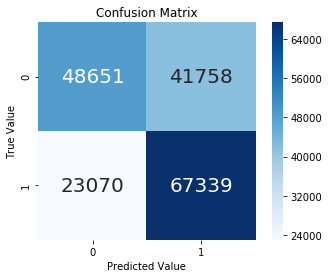

Classification Report for Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy: 0.6414753913372047
Precision:  0.6172397041165202
Recall:  0.7448262894180889
F1 Score:  0.6750573917576413
Time Elapsed:  1.2549679279327393  secs


In [37]:
accuracy_1, f1_1, T1 = kfoldcv1Model(Xrf_smote, Yrf_smote, Perceptron())

## One Classifier Model: Naive Bayes

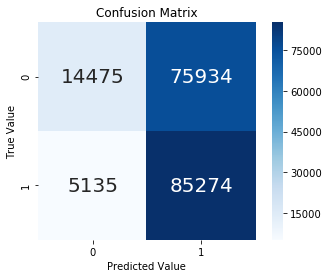

Classification Report for GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy: 0.5516585558212638
Precision:  0.528968785668205
Recall:  0.9432025572675287
F1 Score:  0.6778079382553643
Time Elapsed:  1.0086472034454346  secs


In [38]:
accuracy_2, f1_2, T2 = kfoldcv1Model(Xrf_smote, Yrf_smote, GaussianNB())

## One Classifier Model: Decision Tree

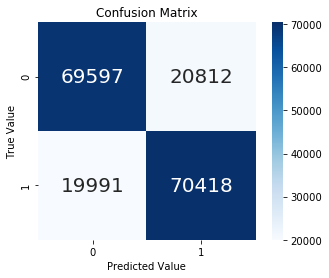

Classification Report for DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy: 0.7743425755210167
Precision:  0.7718732872958457
Recall:  0.7788826333661472
F1 Score:  0.7753621193686376
Time Elapsed:  8.58218002319336  secs


In [39]:
accuracy_3, f1_3, T3 = kfoldcv1Model(Xrf_smote, Yrf_smote, DecisionTreeClassifier())

## One Classifier Model: Linear SVC 

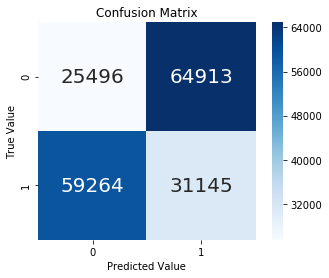

Classification Report for LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.313247699952656
Precision:  0.3242311936538341
Recall:  0.3444900397084361
F1 Score:  0.33405374677556887
Time Elapsed:  6.577644109725952  secs


In [40]:
accuracy_4, f1_4, T4 = kfoldcv1Model(Xrf_smote, Yrf_smote, LinearSVC(dual = False, C = 0.3))

## One Classifier Model: Extra Tree

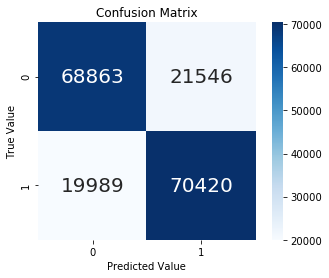

Classification Report for ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.7702941288675298
Precision:  0.7657177652610747
Recall:  0.7789047550575717
F1 Score:  0.7722549691569568
Time Elapsed:  2.0421249866485596  secs


In [41]:
accuracy_5, f1_5, T5 = kfoldcv1Model(Xrf_smote, Yrf_smote, ExtraTreeClassifier())

## Ensemble Model 1: Perceptron, Naive Bayes, Decision tree 

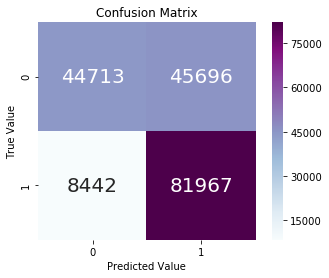

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) GaussianNB(priors=None, var_smoothing=1e-09) DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy: 0.7005965922591214
Precision:  0.6420576047876049
Recall:  0.9066243404970744
F1 Score:  0.7517425437470194
Time Elapsed:  11.300517797470093  secs


In [42]:
accuracy_6, f1_6, T6 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                      Perceptron(), 
                                      GaussianNB(), 
                                      DecisionTreeClassifier())

## Ensemble Model 2: Perceptron, Naive Bayes, Linear SVC

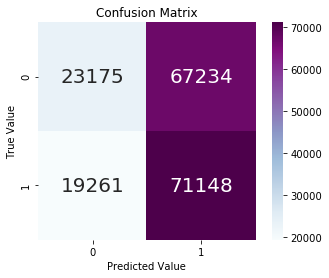

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) GaussianNB(priors=None, var_smoothing=1e-09) LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.52164885001586
Precision:  0.5141420126895117
Recall:  0.7869570507360992
F1 Score:  0.6219475416428094
Time Elapsed:  9.104327201843262  secs


In [43]:
accuracy_7, f1_7, T7 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                      Perceptron(), 
                                      GaussianNB(), 
                                      LinearSVC(dual = False, C = 0.3))

## Ensemble Model 3: Perceptron, Naive Bayes, Extra Tree

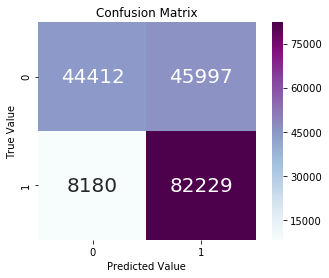

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) GaussianNB(priors=None, var_smoothing=1e-09) ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.7003808540166102
Precision:  0.6412817993230702
Recall:  0.9095222820736873
F1 Score:  0.7522034440963249
Time Elapsed:  4.454015016555786  secs


In [44]:
accuracy_8, f1_8, T8 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                      Perceptron(), 
                                      GaussianNB(),
                                      ExtraTreeClassifier())

## Ensemble Model 4: Perceptron, Decision Tree, Linear SVC

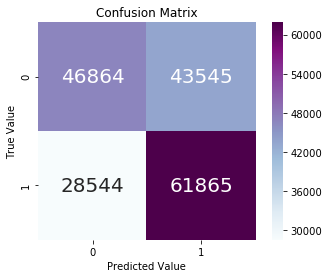

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.601318141972323
Precision:  0.586898776207191
Recall:  0.6842792199891604
F1 Score:  0.6318590126596499
Time Ela

In [45]:
accuracy_9, f1_9, T9 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                      Perceptron(), 
                                      DecisionTreeClassifier(), 
                                      LinearSVC(dual = False, C = 0.3))

## Ensemble Model 5: Perceptron, Decision Tree, Extra Tree

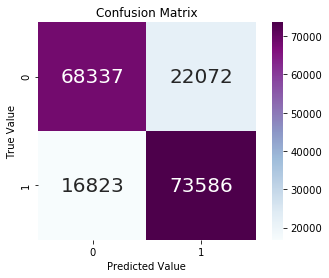

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.78

In [46]:
accuracy_10, f1_10, T10 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         Perceptron(), 
                                         DecisionTreeClassifier(), 
                                         ExtraTreeClassifier())

## Ensemble Model 6: Perceptron, Linear SVC, Extra Tree

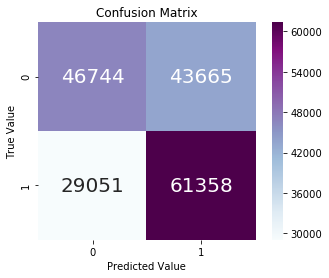

Classification Report for  Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False) LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.5978504489022551
Precision:  0.5842339297106348
Recall:  0.678671371213043
F1 Score:  0.6279217323672683
Time Elapsed:  9.86362910270691

In [47]:
accuracy_11, f1_11, T11 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         Perceptron(), 
                                         LinearSVC(dual = False, C = 0.3), 
                                         ExtraTreeClassifier())

## Ensemble Model 7: Naive Bayes, Decision Tree, Linear SVC

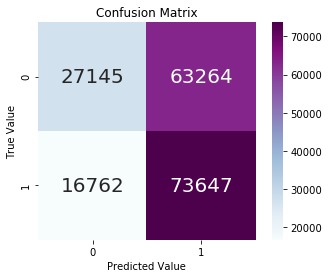

Classification Report for  GaussianNB(priors=None, var_smoothing=1e-09) DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Accuracy: 0.5574250359496449
Precision:  0.5379187939610404
Recall:  0.814598104171045
F1 Score:  0.6479588245644906
Time Elapsed:  18.16699719429016  secs


In [48]:
accuracy_12, f1_12, T12 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         GaussianNB(), 
                                         DecisionTreeClassifier(), 
                                         LinearSVC(dual = False, C = 0.3))

## Ensemble Model 8: Naive Bayes, Decision Tree, Extra Tree

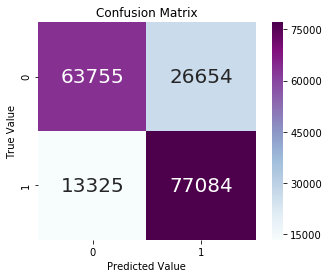

Classification Report for  GaussianNB(priors=None, var_smoothing=1e-09) DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.7789002893757202
Precision:  0.7430642580346642
Recall:  0.8526142308840934
F1 Score:  0.7940787135521022
Time Elapsed:  12.008816003799438  secs


In [49]:
accuracy_13, f1_13, T13 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         GaussianNB(), 
                                         DecisionTreeClassifier(), 
                                         ExtraTreeClassifier())

## Ensemble Model 9: Naive Bayes, Linear SVC, Extra Tree 

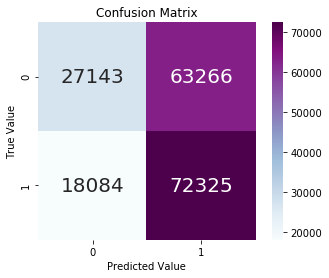

Classification Report for  GaussianNB(priors=None, var_smoothing=1e-09) LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.5501026067671704
Precision:  0.5334056095168558
Recall:  0.799975666139433
F1 Score:  0.6400442477876106
Time Elapsed:  9.441408157348633  secs


In [50]:
accuracy_14, f1_14, T14 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         GaussianNB(), 
                                         LinearSVC(dual = False, C = 0.3), 
                                         ExtraTreeClassifier())

## Ensemble Model 10: Decision Tree, Linear SVC, Extra Tree 

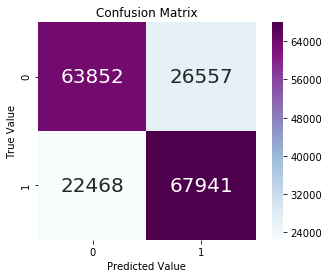

Classification Report for  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') LinearSVC(C=0.3, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')
Accuracy: 0.7288712613616449
Precision:  0.7189675971978243
Recall:  0.7514849185

In [51]:
accuracy_15, f1_15, T15 = kfoldcv3Models(Xrf_smote, Yrf_smote, 
                                         DecisionTreeClassifier(), 
                                         LinearSVC(dual = False, C = 0.3), 
                                         ExtraTreeClassifier())

## Ensemble Model 11: All 5 Classifiers

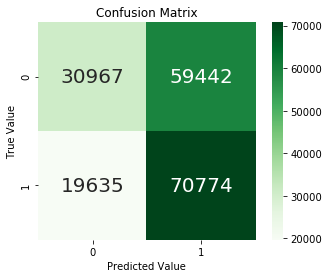

Classification Report for all 5 Classifiers
Accuracy: 0.562672877862983
Precision:  0.5435123179947164
Recall:  0.7828202944397129
F1 Score:  0.6415773371104816
Time Elapsed:  18.246505975723267  secs


In [52]:
accuracy_16, f1_16, T16 = kfoldcv5Models(Xrf_smote, Yrf_smote)

## Ensemble Model 12: Random Forest

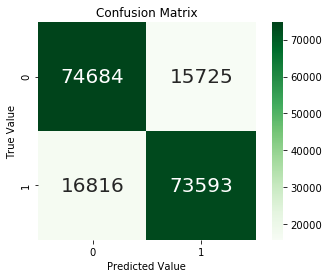

Classification Report for Random Forest
Accuracy: 0.8200348623674916
Precision:  0.823943661971831
Recall:  0.8140008185025827
F1 Score:  0.81894206212756
Time Elaped:  9.729307174682617  secs


In [53]:
accuracy_17, f1_17, T17 = kfoldcvRF(Xrf_smote, Yrf_smote)

In [54]:
# Create lists of accuracies, F1 scores, times, and labels
ensemble_accuracy = [accuracy_1, accuracy_2, accuracy_3, accuracy_4, 
                     accuracy_5, accuracy_6,accuracy_7, accuracy_8, 
                     accuracy_9, accuracy_10, accuracy_11, accuracy_12,
                     accuracy_13, accuracy_14, accuracy_15, accuracy_16, accuracy_17]
ensemble_f1 = [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, 
               f1_9, f1_10, f1_11, f1_12, f1_13, f1_14, f1_15, f1_16, f1_17]
ensemble_time = [T1, T2, T3, T4, T5, T6, T7, T8, 
                 T9, T10, T11, T12, T13, T14, T15, T16, T17]

ensemble_label = ['P', 'NB', 'DT', 'SVC', 'ET', 
                  'P, NB, DT', 'P, NB, SVC', 'P, NB, ET', 'P, DT, SVC', 
                  'P, DT, ET', 'P, SVC, ET', 'NB, DT, SVC', 'NB, DT, ET',
                  'NB, SVC, ET', 'DT, SVC, ET', 'P, NB, DT, SVC, ET', 'RF']

In [55]:
# Create a dataframe to store each type of data 
sorted_accuracy = pd.DataFrame({'Accuracy':ensemble_accuracy}, 
                index =ensemble_label).reset_index().sort_values('Accuracy')
sorted_f1 = pd.DataFrame({'F1_Score':ensemble_f1}, 
                index = ensemble_label).reset_index().sort_values('F1_Score')
sorted_time = pd.DataFrame({'Time':ensemble_time}, 
                index = ensemble_label).reset_index().sort_values('Time')

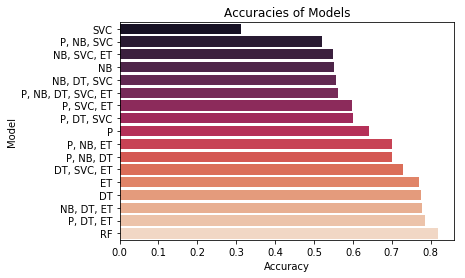

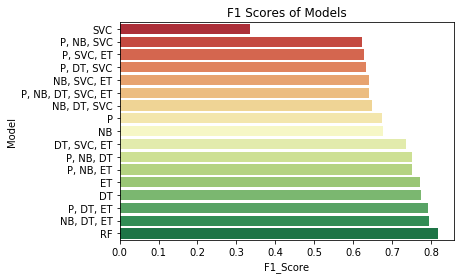

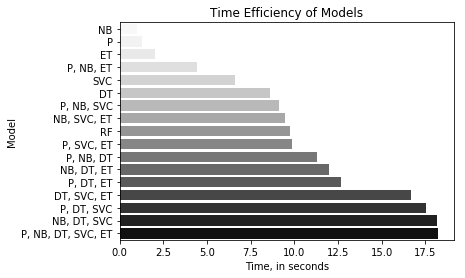

In [56]:
# Plot the accuracies, F1 scores and time efficiency 
# on 3 different plots 
sns.barplot(y = 'index', x = 'Accuracy', data = sorted_accuracy, palette = 'rocket')
plt.ylabel("Model")
plt.title("Accuracies of Models")
plt.show()
sns.barplot(y = 'index', x = 'F1_Score', data = sorted_f1, palette = 'RdYlGn')
plt.ylabel("Model")
plt.title("F1 Scores of Models")
plt.show()
sns.barplot(y = 'index', x = 'Time', data = sorted_time, palette = 'Greys')
plt.ylabel("Model")
plt.xlabel("Time, in seconds")
plt.title("Time Efficiency of Models")
plt.show()